# FLU VACCINE UPTAKE PREDICTION
## Phase 3 Machine Learning Project

### 1.0 Business Understanding

**1.1 The Public Health Context:**

Seasonal influenza continues to pose significant health risks despite the availability of effective vaccines. However, vaccination rates remain suboptimal in many populations, suggesting the presence of behavioral, informational, and structural barriers to uptake.

**1.2 Stakeholder:** 

Centers for Disease Control and Prevention (CDC) Public Health Division

**1.3 Business Problem:**

Current public health vaccination campaigns are often broad and population-wide. While this approach maximizes exposure, it can lead to inefficiencies:
* Resources may be distributed across individuals who would vaccinate regardless.
* Vaccine-hesitant populations may remain unengaged.
* Outreach efforts may lack personalization based on behavioral or demographic differences.

This raises a key strategic question:
**Can we identify individuals who are least likely to receive a flu vaccine, so that outreach efforts can be more targeted and efficient?**

By answering this question, public health agencies can allocate resources more effectively and design interventions that address specific barriers to vaccination.

**1.4 Project Objective:**

The objective of this project is to build predictive classification models that estimate the probability that an individual receives:
* The H1N1 vaccine
* The seasonal flu vaccine

These predictions can support:
* More targeted communication campaigns
* Better understanding of behavioral drivers of vaccination.

### 2.0 Data Understanding
**2.1 Dataset Overview:**

The dataset used in this project originates from the 2009 National H1N1 Flu Survey. It contains survey responses collected to understand vaccination behavior during the H1N1 influenza outbreak.

The dataset is structured into separate files:
* training_set_features.csv – Contains demographic, behavioral, and health-related features.
* training_set_labels.csv – Contains the target variables indicating vaccine uptake.
* test_set_features.csv – Contains feature data for prediction (not used for model training in this analysis).

For this project, we focus on the training datasets.

**2.2 Target Variables:**

The training_set_labels.csv file includes two binary target variables:

* h1n1_vaccine

    * 0 = Did not receive H1N1 vaccine
    * 1 = Received H1N1 vaccine

* seasonal_vaccine

    * 0 = Did not receive seasonal flu vaccine
    * 1 = Received seasonal flu vaccine

Each represents whether a respondent received the respective vaccine.

**2.3 Feature Description**

The training_set_features.csv dataset contains:
* Demographic information (age, education level, employment status)
* Health-related conditions
* Behavioral indicators (preventive measures, doctor recommendations)
* Risk perception
* Opinion-based responses

### 3.0 Data Preparation
This section outlines the preprocessing steps required to transform the raw survey data into a format suitable for machine learning modelling.
Overview

In this section, we prepare the dataset for modeling. This includes:

* Importing necessary libraries
* Loading the feature and label datasets
* Merging datasets
* Inspecting data structure
* Identifying missing values

#### 3.1 Import Libraries

In [47]:
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    roc_auc_score
)

# Set display
pd.set_option("display.max_columns", None)


#### 3.2 Load Dataset

In [48]:
features = pd.read_csv("../data/training_set_features.csv")
labels = pd.read_csv("../data/training_set_labels.csv")
test = pd.read_csv("../data/test_set_features.csv")

In [49]:
print("Features shape:", features.shape)

Features shape: (26707, 36)


In [50]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

In [51]:
print("Labels shape:", labels.shape)

Labels shape: (26707, 3)


In [52]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   respondent_id     26707 non-null  int64
 1   h1n1_vaccine      26707 non-null  int64
 2   seasonal_vaccine  26707 non-null  int64
dtypes: int64(3)
memory usage: 626.1 KB


#### 3.3 Data Merging

Each respondent has both survey answers (features) and vaccination outcomes (labels).
Merging creates complete profiles.

In [53]:
train = pd.merge(features, labels, on='respondent_id', how='inner')
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

In [54]:
#separate target variables from predictor variables
X_train = train.drop(['respondent_id', 'h1n1_vaccine', 'seasonal_vaccine'], axis=1)
y_h1n1 = train['h1n1_vaccine']
y_seasonal = train['seasonal_vaccine']

#### 3.4 Missing Data Handling

* Categorical features: Replace with mode
* Numerical features: Replace with median

In [55]:
# Check data types
print("\nData types in our features:")
print(X_train.dtypes.value_counts())


Data types in our features:
float64    23
object     12
dtype: int64


In [56]:
# Identify columns with excessive missing data (>40% missing)
missing_threshold = 0.4
missing_ratio = X_train.isnull().mean()
high_missing_cols = missing_ratio[missing_ratio > missing_threshold].index.tolist()

In [57]:
print(f"\nFeatures excluded due to >40% missing data:")
print(f"Columns: {high_missing_cols}")
print(f"Reason: Insufficient data quality for reliable predictions")

# Columns we're keeping
kept_cols = [col for col in X_train.columns if col not in high_missing_cols]
print(f"\nFeatures retained for modeling: {len(kept_cols)} columns")
print(f"Sample: {kept_cols[:10]}...")

# Business rationale documentation
# feature_rationale = """


Features excluded due to >40% missing data:
Columns: ['health_insurance', 'employment_industry', 'employment_occupation']
Reason: Insufficient data quality for reliable predictions

Features retained for modeling: 32 columns
Sample: ['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds', 'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands', 'behavioral_large_gatherings', 'behavioral_outside_home', 'behavioral_touch_face', 'doctor_recc_h1n1']...


In [58]:
# Separate numerical and categorical columns based on data type
numerical_cols = X_train.select_dtypes(include=['float64']).columns.tolist()

In [59]:
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

In [60]:
#check for missing values
missing_values = X_train.isnull().sum()
missing_values


h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
marital_status                  1408
r

#### 3.5 Train-Test Split

In [61]:
# Split for SEASONAL vaccine model (for Logistic Regression)
X_train_seasonal, X_test_seasonal, y_train_seasonal, y_test_seasonal = train_test_split(
    X_train, y_seasonal,
    test_size=0.2,
    random_state=42,
    stratify=y_seasonal
)

# Split for H1N1 vaccine model (for Decision Tree)
X_train_h1n1, X_test_h1n1, y_train_h1n1, y_test_h1n1 = train_test_split(
    X_train, y_h1n1,
    test_size=0.2,
    random_state=42,
    stratify=y_h1n1
)


### 4.0 Modeling
MODEL SELECTION STRATEGY:

Model 1: Logistic Regression (Baseline for Seasonal Vaccine)
- Purpose: Establish interpretable baseline performance
- Business Value: Identify linear relationships between features and vaccination
- Why Seasonal?: Seasonal flu has historical data patterns, likely more linear

Model 2: Decision Tree Classifier (Advanced for H1N1 Vaccine)
- Purpose: Capture complex non-linear relationships from pandemic response
- Business Value: Identify actionable decision rules for emergency interventions
- Why H1N1?: Novel pandemic behavior may have non-linear patterns

Progressive Complexity Strategy:
1. Start simple (Logistic Regression) - establishes baseline
2. Move to complex (Decision Tree) - captures interactions
3. Optimize (Hyperparameter tuning) - maximizes performance
4. Evaluate on test data - validates generalization

#### 4.1 CREATE TWO PREPROCESSING PIPELINES

In [62]:
# PIPELINE 1: WITH SCALING (FOR LOGISTIC REGRESSION)
#Fill empty spots with median
# and scale them so large numbers
num_transformer_scaled = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [63]:
# Fill empty spots with the most common word 
# and turn words into 1s and 0s (One-Hot Encoding).
cat_transformer_scaled = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [64]:
preprocessor_scaled = ColumnTransformer([
    ('numerical', num_transformer_scaled, numerical_cols),
    ('categorical', cat_transformer_scaled, categorical_cols)
])

#### 4.2 PROCESS FOR LOGISTIC REGRESSION (WITH SCALING)

In [65]:
#create pipeline
logistic_pipeline_seasonal = Pipeline(steps=[
    ('preprocessor', preprocessor_scaled),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

In [66]:

# Train the model
logistic_pipeline_seasonal.fit(X_train_seasonal, y_train_seasonal)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'behavioral_outside_h...
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['age_group', 'education',
                                                   'race', 'sex',
                                                   'income_poverty',
                                                   'marital_status',
                                                   'rent_or_own',
                                                   'employment_status',
                                                   'hhs_geo_region',
                                                   'census_msa',
                                                   'employment_industry',
                                                   'employment_occupation'])])),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

In [67]:
# Predictions
y_pred_logistic_seasonal = logistic_pipeline_seasonal.predict(X_test_seasonal)
y_pred_proba_logistic_seasonal = logistic_pipeline_seasonal.predict_proba(X_test_seasonal)[:, 1]

In [68]:
# Evaluation
#identifying non-vaccinators
tn, fp, fn, tp = confusion_matrix(y_test_seasonal, y_pred_logistic_seasonal).ravel()
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
roc_auc = roc_auc_score(y_test_seasonal, y_pred_proba_logistic_seasonal)

In [69]:
print(f"RECALL (Non-vaccinator identification rate): {recall:.4f}")
print(f"Secondary Metrics:")
print(f"  - Precision: {precision:.4f}")
print(f"  - F1-Score: {f1:.4f}")
print(f"  - ROC-AUC: {roc_auc:.4f}")

RECALL (Non-vaccinator identification rate): 0.7402
Secondary Metrics:
  - Precision: 0.7807
  - F1-Score: 0.7600
  - ROC-AUC: 0.8557


In [70]:
print("CLASSIFICATION REPORT \n")

print(classification_report(y_test_seasonal, y_pred_logistic_seasonal, 
                           target_names=['Vaccinated', 'Non-vaccinated']))


CLASSIFICATION REPORT 

                precision    recall  f1-score   support

    Vaccinated       0.78      0.82      0.80      2855
Non-vaccinated       0.78      0.74      0.76      2487

      accuracy                           0.78      5342
     macro avg       0.78      0.78      0.78      5342
  weighted avg       0.78      0.78      0.78      5342



In [71]:
print("INTERPRETATION")
print(f"""
Recall = {recall:.2%}: We correctly identify {recall:.2%} of actual non-vaccinators
Out of 100 non-vaccinators, we flag {recall*100:.0f} for intervention
False Negatives ({fn}): {fn} missed opportunities for outreach
Model ROC-AUC: {roc_auc:.3f} (discrimination ability)
""")

INTERPRETATION

Recall = 74.02%: We correctly identify 74.02% of actual non-vaccinators
Out of 100 non-vaccinators, we flag 74 for intervention
False Negatives (646): 646 missed opportunities for outreach
Model ROC-AUC: 0.856 (discrimination ability)



#### 4.3 PROCESS FOR DECISION TREE (WITHOUT SCALING)

**PIPELINE 2: WITHOUT SCALING (FOR DECISION TREE)**

In [72]:
# Numerical pipeline unscaled
numerical_unscaled = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))  # Just impute, no scaling
])
#categorical pipeline unscaled
categorical_unscaled = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor_unscaled = ColumnTransformer([
    ('numerical', numerical_unscaled, numerical_cols),
    ('categorical', categorical_unscaled, categorical_cols)
])


In [73]:
# Create pipeline with preprocessing and model (initial, untuned)
tree_model = Pipeline(steps=[
    ('preprocessor', preprocessor_unscaled),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Train the model
tree_model.fit(X_train_h1n1, y_train_h1n1)

# Predictions
y_pred_tree = tree_model.predict(X_test_h1n1)
y_pred_proba_tree = tree_model.predict_proba(X_test_h1n1)[:, 1]

In [74]:
# Evaluation
print("PERFORMANCE METRICS (Initial Untuned Tree)")

tn, fp, fn, tp = confusion_matrix(y_test_h1n1, y_pred_tree).ravel()
recall_tree = tp / (tp + fn) if (tp + fn) > 0 else 0
precision_tree = tp / (tp + fp) if (tp + fp) > 0 else 0
f1_tree = 2 * (precision_tree * recall_tree) / (precision_tree + recall_tree) if (precision_tree + recall_tree) > 0 else 0
roc_auc_tree = roc_auc_score(y_test_h1n1, y_pred_proba_tree)

print(f"\nPrimary Metric - RECALL: {recall_tree:.4f}")
print(f"Secondary Metrics:")
print(f"  - Precision: {precision_tree:.4f}")
print(f"  - F1-Score: {f1_tree:.4f}")
print(f"  - ROC-AUC: {roc_auc_tree:.4f}")

print("\n")
print("CLASSIFICATION REPORT")
print(classification_report(y_test_h1n1, y_pred_tree,
                           target_names=['Vaccinated', 'Non-vaccinated']))


PERFORMANCE METRICS (Initial Untuned Tree)

Primary Metric - RECALL: 0.4670
Secondary Metrics:
  - Precision: 0.4291
  - F1-Score: 0.4473
  - ROC-AUC: 0.6497


CLASSIFICATION REPORT
                precision    recall  f1-score   support

    Vaccinated       0.85      0.83      0.84      4207
Non-vaccinated       0.43      0.47      0.45      1135

      accuracy                           0.75      5342
     macro avg       0.64      0.65      0.64      5342
  weighted avg       0.76      0.75      0.76      5342



#### 4.4 Model Comparison & Iterative Justification

In [75]:
comparison_data = {
    'Metric': ['Recall', 'Precision', 'F1-Score', 'ROC-AUC'],
    'Logistic Regression (Seasonal)': [recall, precision, f1, roc_auc],
    'Decision Tree (H1N1) - Initial': [recall_tree, precision_tree, f1_tree, roc_auc_tree]
}
comparison_df = pd.DataFrame(comparison_data).round(4)
comparison_df 

,Metric,Logistic Regression (Seasonal),Decision Tree (H1N1) - Initial
0,Recall,0.7402,0.4670
1,Precision,0.7807,0.4291
2,F1-Score,0.7600,0.4473
3,ROC-AUC,0.8557,0.6497


#### 4.5 Hyperparameter tuning

In [76]:

from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'classifier__max_depth': [3, 5, 7, 10, None],
    'classifier__min_samples_split': [2, 5, 10, 20],
    'classifier__min_samples_leaf': [1, 2, 5, 10],
    'classifier__criterion': ['gini', 'entropy']
}

# Create pipeline for tuning
tree_tune = Pipeline(steps=[
    ('preprocessor', preprocessor_unscaled),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Grid search with cross-validation
grid_search = GridSearchCV(
    tree_tune,
    param_grid,
    cv=5,
    scoring='recall',  # Primary metric is RECALL
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_h1n1, y_train_h1n1)

print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Recall: {grid_search.best_score_:.4f}")

# Evaluate tuned model on test set
best_tree = grid_search.best_estimator_
y_pred_tuned = best_tree.predict(X_test_h1n1)
y_pred_proba_tuned = best_tree.predict_proba(X_test_h1n1)[:, 1]

tn, fp, fn, tp = confusion_matrix(y_test_h1n1, y_pred_tuned).ravel()
recall_tuned = tp / (tp + fn)
precision_tuned = tp / (tp + fp)
f1_tuned = 2 * (precision_tuned * recall_tuned) / (precision_tuned + recall_tuned)
roc_auc_tuned = roc_auc_score(y_test_h1n1, y_pred_proba_tuned)

print("\n")
print("TUNED MODEL PERFORMANCE")
print(f"Recall: {recall_tuned:.4f} (vs initial {recall_tree:.4f})")
print(f"Precision: {precision_tuned:.4f}")
print(f"F1-Score: {f1_tuned:.4f}")
print(f"ROC-AUC: {roc_auc_tuned:.4f}")

Fitting 5 folds for each of 160 candidates, totalling 800 fits

Best Parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Best Cross-Validation Recall: 0.4567


TUNED MODEL PERFORMANCE
Recall: 0.4670 (vs initial 0.4670)
Precision: 0.4291
F1-Score: 0.4473
ROC-AUC: 0.6497


#### 4.6 feature selection



FEATURE IMPORTANCE (Initial Decision Tree - Top 10)


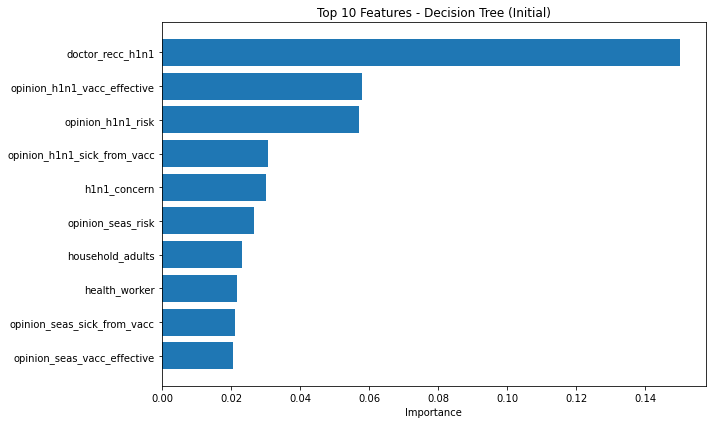

In [77]:

# Visualize initial feature importance
print("\n")
print("FEATURE IMPORTANCE (Initial Decision Tree - Top 10)")

# Get feature names after preprocessing
feature_names = []
feature_names.extend(numerical_cols)

# Get categorical feature names after one-hot encoding
cat_encoder = tree_model.named_steps['preprocessor'].named_transformers_['categorical'].named_steps['onehot']
cat_feature_names = cat_encoder.get_feature_names_out(categorical_cols)
feature_names.extend(cat_feature_names)

# Get importances
importances = tree_model.named_steps['classifier'].feature_importances_

# Create DataFrame
importance_df = pd.DataFrame({
    'feature': feature_names[:len(importances)],
    'importance': importances
}).sort_values('importance', ascending=False).head(10)

#print(importance_df.to_string(index=False))

# Visualization
plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Importance')
plt.title('Top 10 Features - Decision Tree (Initial)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### 5.0 Submission

In [78]:
print(f"Features (X_train) shape: {X_train.shape}")
print(f"Target (y_seasonal) shape: {y_seasonal.shape}")

Features (X_train) shape: (26707, 35)
Target (y_seasonal) shape: (26707,)


In [ ]:
# Load test data
test_features = pd.read_csv("../data/test_set_features.csv")
test_ids = test_features['respondent_id']
X_test_final = test_features.drop('respondent_id', axis=1)

# Train final models on ALL data
# Final Logistic Regression for Seasonal
final_logistic = LogisticRegression(random_state=42, max_iter=1000)
final_logistic.fit(preprocessor_scaled.fit_transform(X_train_seasonal), y_train_seasonal)

# Final Decision Tree for H1N1
clean_params = {k.replace('classifier__', ''): v for k, v in grid_search.best_params_.items()}
final_tree = DecisionTreeClassifier(**clean_params, random_state=42)
#final_tree = DecisionTreeClassifier(**grid_search.best_params_, random_state=42)
final_tree.fit(preprocessor_unscaled.fit_transform(X_train_h1n1), y_train_h1n1)

# Generate predictions
print("Generating predictions...")
h1n1_pred = final_tree.predict_proba(preprocessor_unscaled.transform(X_test_final))[:, 1].round(1)
seasonal_pred = final_logistic.predict_proba(preprocessor_scaled.transform(X_test_final))[:, 1].round(1)
# Create submission
submission = pd.DataFrame({
    'respondent_id': test_ids,
    'h1n1_vaccine': h1n1_pred,
    'seasonal_vaccine': seasonal_pred
})

# Save
submission.to_csv('flu_vaccine_submission.csv', index=False)
print("✓ Submission saved to 'flu_vaccine_submission.csv'")
print(submission.head())

Generating predictions...
✓ Submission saved to 'flu_vaccine_submission.csv'
   respondent_id  h1n1_vaccine  seasonal_vaccine
0          26707           0.0               0.3
1          26708           0.0               0.0
2          26709           0.0               0.6
3          26710           0.0               0.9
4          26711           1.0               0.5
